In [13]:
# Imports
import os

from PIL import Image
import numpy as np

import warnings
import math
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu

from networks import U2NET

# Constants
device = "cpu"
image_dir = "input_images"
result_dir = "output_images"
checkpoint_path = os.path.join("trained_checkpoint", "cloth_segm_u2net_latest.pth")
do_palette = True

assert os.path.exists(image_dir)
assert os.path.exists(result_dir)
assert os.path.exists(checkpoint_path)

# Utils
def get_palette(num_cls):
    """Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [5]:
# Preprocessing pipe-line
transform_rgb = transforms.Compose([transforms.ToTensor(), Normalize_image(0.5, 0.5)])

# Define model and load weights
net = U2NET(in_ch=3, out_ch=4)
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

----checkpoints loaded from path: trained_checkpoint/cloth_segm_u2net_latest.pth----


In [11]:
# Let's check the size of the model: it's 168.44 MB
convert_size(os.path.getsize(checkpoint_path))

'168.44 MB'

readme-img1.png


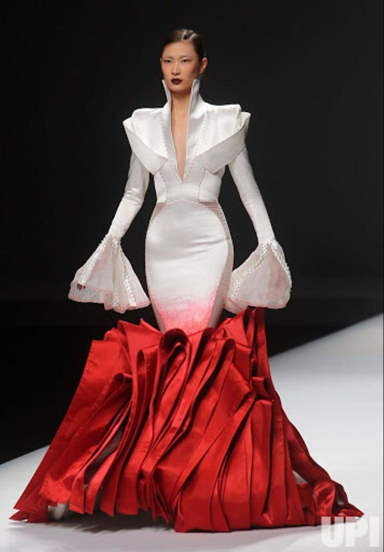

readme-img2.png


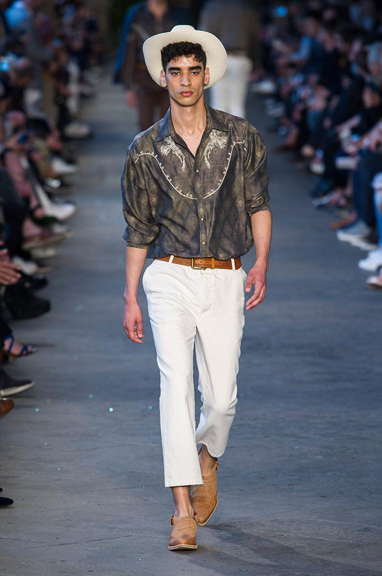

readme-img3.png


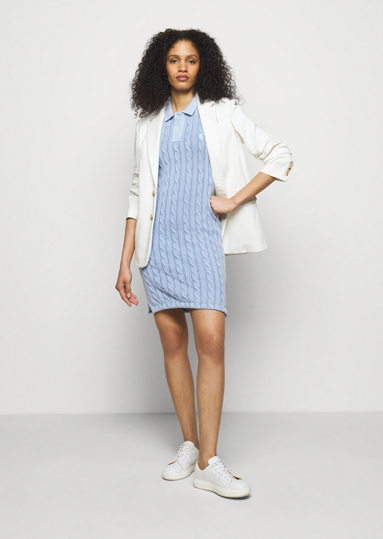

In [42]:
# Let's view sample images
images_list = sorted(os.listdir(image_dir))

for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
    print(image_name)
    display(img.resize([i//2 for i in img.size])) # Downsize

Let's benchmark the preprocessing and inference on CPU at full resolution

In [27]:
img.size

(767, 1079)

In [24]:
%%timeit
image_tensor = transform_rgb(img)
image_tensor = torch.unsqueeze(image_tensor, 0)

19.7 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
output_tensor = net(image_tensor.to(device))

/Users/au478108/opt/miniconda3/envs/cloth-segmentation/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


6.42 s ± 453 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
o = F.log_softmax(output_tensor[0], dim=1)
o = torch.max(o, dim=1, keepdim=True)[1]
o = torch.squeeze(o, dim=0)
o = torch.squeeze(o, dim=0)
output_arr = o.cpu().numpy()

9.54 ms ± 821 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So, the model inference for high-resolution images takes a long time on CPU (6.4 s on average),while the pre- and post-processing takes only 20 ms and 10 ms.

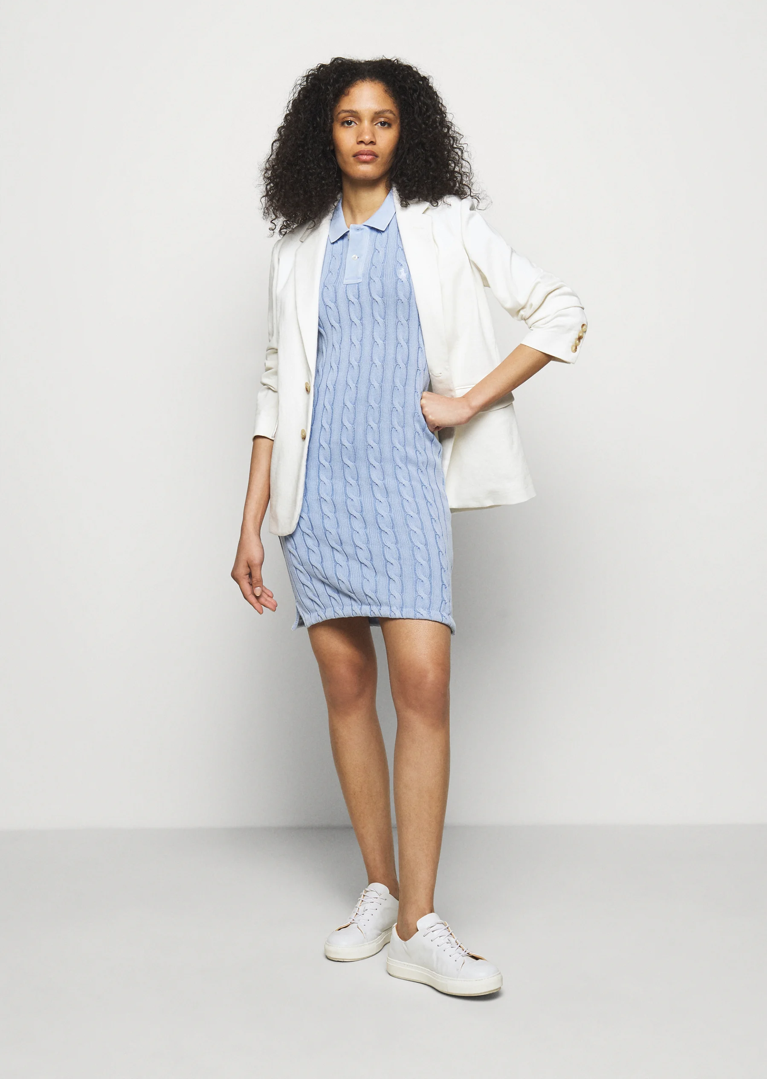

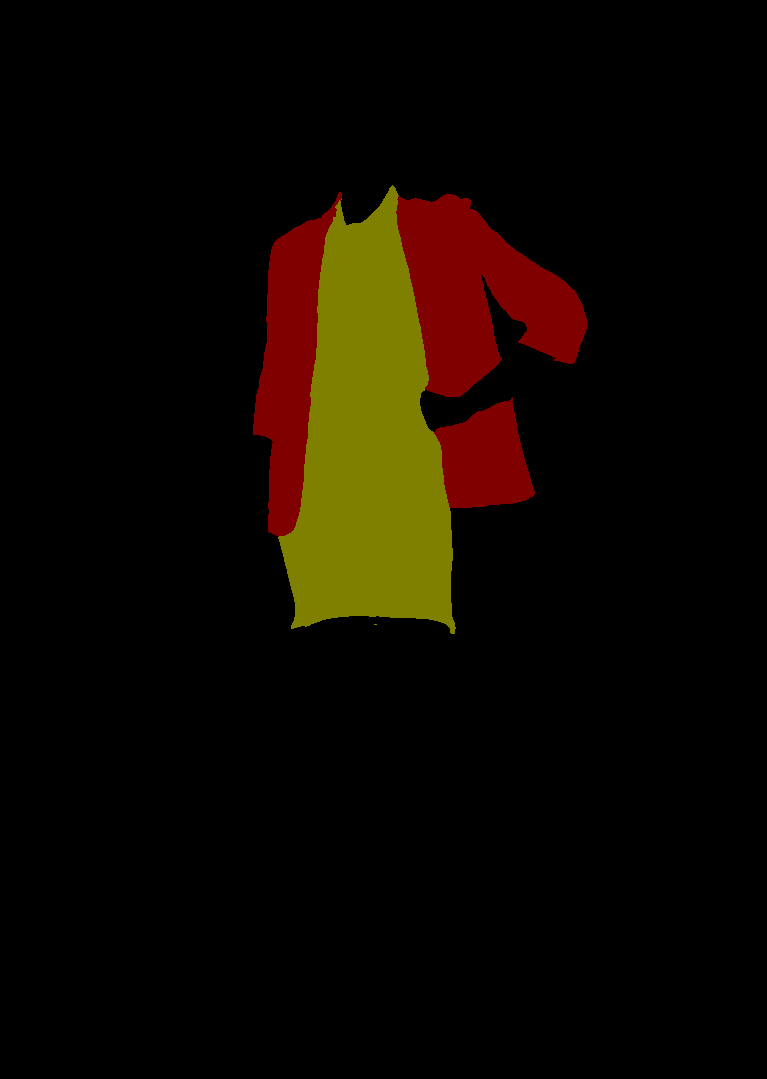

In [45]:
# Let's inspect the results
output_img = Image.fromarray(output_arr.astype("uint8"), mode="L")
if do_palette:
    output_img.putpalette(get_palette(4))

display(img)
display(output_img)

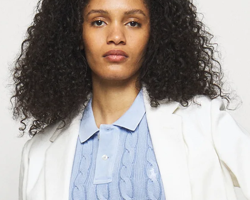

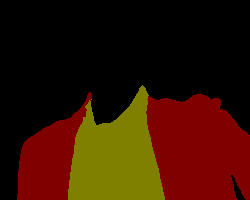

In [51]:
# The hair-border could be tricky, but it seems to handle it well enough

#  .          (left, top, right, bottom)
crop_coords = (250, 100, 500, 300)
display(img.crop(crop_coords))
display(output_img.crop(crop_coords))

In [55]:
# Let's try with half the resolution 
img = Image.open(os.path.join(image_dir, image_name)).convert("RGB")
img = img.resize([i//2 for i in img.size])
image_tensor = transform_rgb(img)
image_tensor = torch.unsqueeze(image_tensor, 0)


In [56]:
%%timeit
output_tensor = net(image_tensor.to(device))

/Users/au478108/opt/miniconda3/envs/cloth-segmentation/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


1.58 s ± 108 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/au478108/opt/miniconda3/envs/cloth-segmentation/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


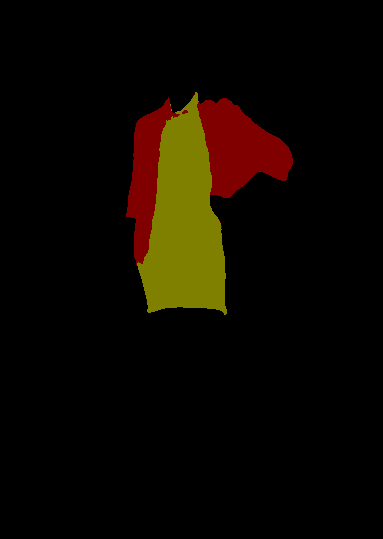

In [61]:
output_tensor = net(image_tensor.to(device))
o = F.log_softmax(output_tensor[0], dim=1)
o = torch.max(o, dim=1, keepdim=True)[1]
o = torch.squeeze(o, dim=0)
o = torch.squeeze(o, dim=0)
output_arr = o.cpu().numpy()

output_img2 = Image.fromarray(output_arr.astype("uint8"), mode="L")
if do_palette:
    output_img2.putpalette(get_palette(4))

display(output_img2)
output_img2.save(os.path.join(result_dir, image_name[:-4] + "-half-res" + ".png"))

We can see that a lot of detail was lost (i.e. sprurious detections of upper-body clothing in red around neck-line, no gap detected around right arm). However, the inference took only 1.6s on average. 

__The inference-time scales linearly with both the width and height. Reducing both dimensions to half the resolution gives a 4x speedup__. 

We we could spend a lot of time optimizing the model, the deceptively simple choice of image size has a massive effect.